In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# Hyperparameters
nn_name = 'data/NeuralModel.pth'
svm_name = 'data/svm.pth'
train_model_svm = False
train_model_NN = False

save_model_svm = True
save_model_NN = True

use_saved_svm = True
use_saved_NN = True

In [39]:
loss_mean_number = 1000
batch_size = 64
data_size = 60000

# Models, optimizers and loss function

In [43]:
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return logits

if use_saved_svm:
    svm_model = torch.load(svm_name).to(device)
else:
    svm_model = SVM().to(device)

In [5]:
# Define MLP model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 120),
            nn.ReLU(),
            nn.Linear(120, 90),
            nn.ReLU(),
            nn.Linear(90, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return F.softmax(logits, dim=1)

if use_saved_NN:
    NN_model = torch.load(nn_name).to(device)
else:
    NN_model = NeuralNetwork().to(device)

In [6]:
optimizer_NN = torch.optim.Adam(NN_model.parameters())
optimizer_svm = torch.optim.Adam(svm_model.parameters())

In [7]:
loss_fn = nn.CrossEntropyLoss()

# MNIST 

In [8]:
mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)


/home/erd/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# Calculate input and label size as integer
input_size = int(batch_size * 0.8 ) + 1
label_size = int(batch_size * 0.2 )
assert(input_size + label_size == batch_size)

# Create data loaders.
train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [10]:
len(test_dataloader.dataset)

10000

In [29]:

def train_loop(train_dataloader, model, loss_fn, optimizer, loss_mean_number=1000):
    model.train()
    train_loss_list = []
    train_loss = 0
    num_batches = len(train_dataloader)
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.type(torch.FloatTensor).to(device=device)
        # Compute prediction and loss
        pred = model(X)
        #create a tearget vector
        t = torch.zeros([1,10], device=device)
        t[0][y] = 1
        #calculate loss
        loss = loss_fn(pred,t)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train loss
        train_loss += loss.item()
        if batch % loss_mean_number == 0 and batch != 0:
                train_loss_list.append(train_loss/loss_mean_number)
                train_loss = 0
        return train_loss_list



In [20]:
def test_loop(test_dataloader, model, loss_fn):
    # size = len(test_dataloader.dataset)
    # num_batches = len(test_dataloader)

    size = 10000
    num_batches = batch_size
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.type(torch.FloatTensor).to(device=device)
            pred = model(X)
            t = torch.zeros([1,10], device=device)
            t[0][y] = 1
            test_loss += loss_fn(pred, t).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [26]:
def epoch_loop(test, train, model, loss, optimizer, epoch_number=10):
    train_loss_list= []
    test_loss_list = []
    accuracy_list = []
    for epoch in range(epoch_number):
        test_loss, accuracy = test_loop(test, model, loss)
        train_loss = train_loop(train, model, loss, optimizer)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        accuracy_list.append(accuracy)
        print(f'for epoch {epoch} : {accuracy=}')
        print(f'{test_loss=} train_loss={mean(train_loss)}')
        print('-'*10)
    return train_loss_list, test_loss_list, accuracy_list

In [22]:
mean = lambda x : sum(x) / len(x)
assert(mean([1,2,3,4,5]) == 3) 

In [34]:
import numpy as np
from matplotlib import ticker
def graph(accuracy, train_loss, test_loss, epoch_number):
    train_loss_list =  np.array(train_loss).flatten()
    test_loss_list = np.array(test_loss).flatten()
    e1 = len(train_loss_list)
    e2 = len(test_loss_list)
    scale = e1/e2 * loss_mean_number
    x1 = np.array([(x+1)* loss_mean_number for x in range(e1)])
    x2 = np.array([x for x in range(e2)])
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    ax1.plot(x1, train_loss_list)
    ax3 = ax2.twinx()
    ax2.plot(x2*scale, test_loss_list)
    ax1.set_ylabel('Train loss')
    ax2.set_ylabel('Test Loss')
    ax3.set_ylabel('Accuracy')
    ax2.set_xlabel('Iteration Number')
    ax3.plot(x2*scale, accuracy_list, color='orange')
    ax3.yaxis.set_major_locator(ticker.MaxNLocator())
    ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    for epoch_number in range(epoch_number):
        if epoch_number == 0:
            label='Epoch'
        else:
            label=''
        ax1.axvline(epoch_number * data_size, label=label, ls='--')
        ax3.axvline(epoch_number * data_size,  ls='--')
    fig.legend()
    

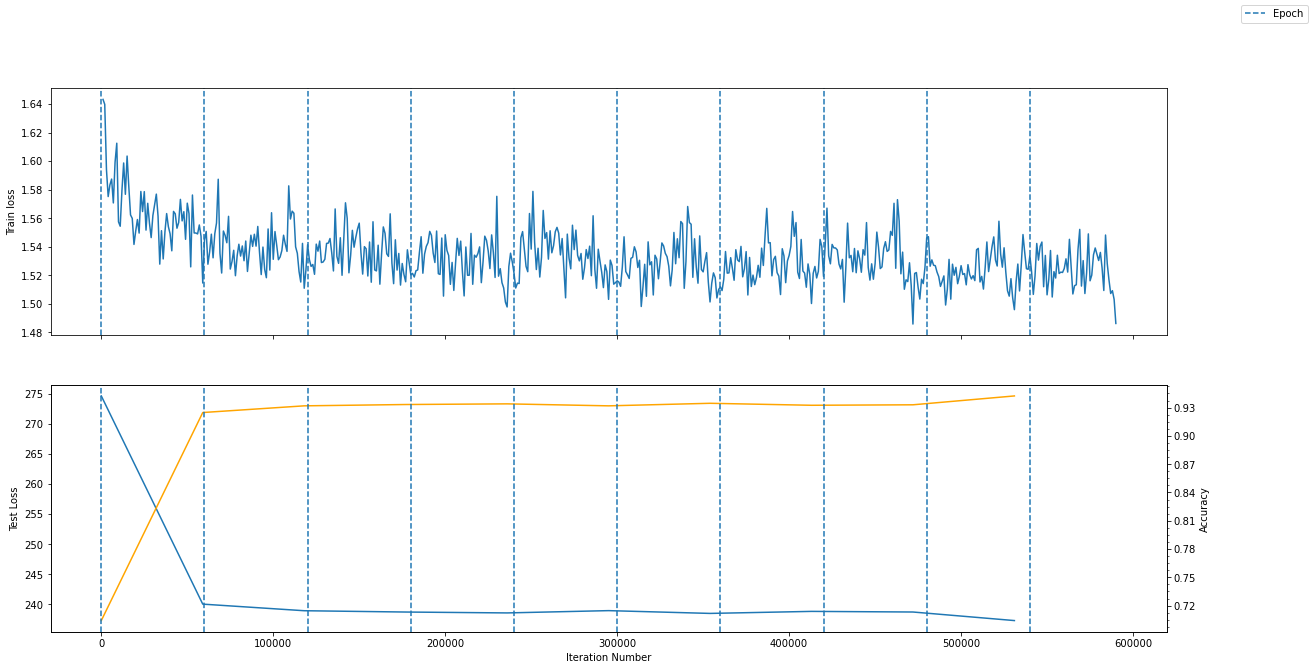

In [37]:
if train_model_nn:
    train_loss, test_loss, accuracy_list = epoch_loop(mnist_test, mnist_train, NN_model, loss_fn,optimizer_NN)

if save_model_NN:
    graph(train_loss, test_loss, 10 )
    torch.save(NN_model, nn_name)

for epoch 0 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 1 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 2 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 3 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 4 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 5 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 6 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 7 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 8 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


for epoch 9 : accuracy=0.1164
test_loss=360.078346170485 train_loss=2.299259821376558
----------


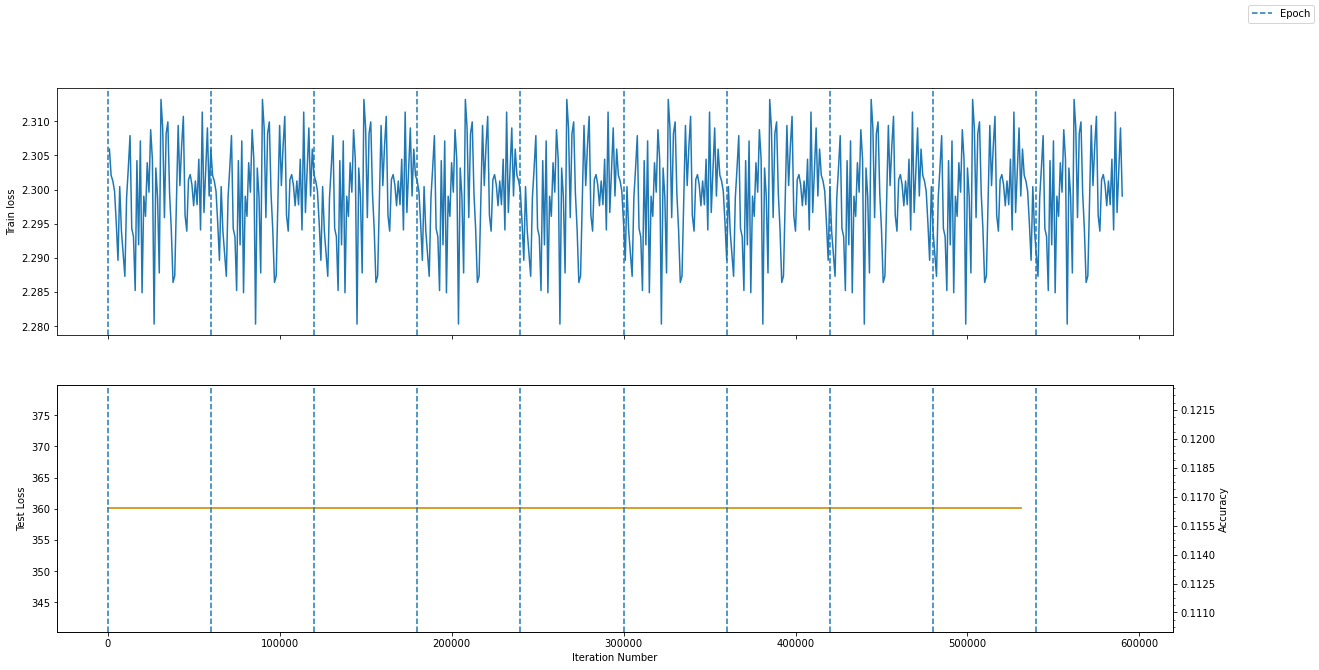

In [44]:
if train_model_svm:
    train_loss, test_loss, accuracy_list = epoch_loop(mnist_test, mnist_train, svm_model, loss_fn,optimizer_svm)
    
if save_model_svm:
    graph(train_loss, test_loss, 10 )
    torch.save(svm_model, svm_name)
